# Final verison for GAME PRICE PREDICTION by team :AABRA-CA-DATA.

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/logical-rythm-2k20-game-price-prediction/steam_sample_submission.csv
/kaggle/input/logical-rythm-2k20-game-price-prediction/steam_test.csv
/kaggle/input/logical-rythm-2k20-game-price-prediction/steam_train.csv


## Importing Libraries

In [2]:
"""For Statistical and Mathematic computing"""
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import itertools
import re
import math

"""For Ploting graphs and Data exploration"""
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

"""For Data preprocessing and Model Preparation"""
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import random
random.seed(2)
from sklearn.preprocessing import StandardScaler


# Getting the training and testing data

In [3]:
train_path = '../input/logical-rythm-2k20-game-price-prediction/steam_train.csv'
test_path = '../input/logical-rythm-2k20-game-price-prediction/steam_test.csv'
train_df = pd.read_csv(train_path)

test_df = pd.read_csv(test_path)
test_id = test_df['appid']

# Previewing data for analysis

In [4]:
train_df.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,708830,The Armament Project,2017-09-28,1,DysTop,DysTop,windows,0,Single-player;Partial Controller Support,Action;Indie,Action;Indie;Space,0,2,2,0,0,0-20000,2.89
1,538000,Hop Step Sing! Kisekiteki Shining! (HQ Edition),2017-06-29,1,Kodansha;Polygon Pictures Inc.;Lantis,Degica,windows,0,Single-player;Partial Controller Support,Casual,Casual;VR;Anime,0,30,4,0,0,0-20000,3.99
2,603530,A Robot Named Fight!,2017-09-07,1,Matt Bitner Games,Matt Bitner Games,windows;mac;linux,0,Single-player;Local Co-op;Shared/Split Screen;...,Violent;Gore;Action;Indie,Action;Metroidvania;Indie,60,271,30,279,279,20000-50000,10.29
3,564040,ZANGEKI WARP,2017-02-15,1,ASTRO PORT,Nyu Media,windows;linux,0,Single-player;Steam Achievements;Steam Trading...,Action;Indie,Action;Indie;Shoot 'Em Up,53,16,0,0,0,0-20000,4.79
4,951940,Almost There: The Platformer,2019-02-19,1,Bony Yousuf,The Quantum Astrophysicists Guild,windows;mac;linux,0,Single-player;Steam Achievements;Full controll...,Action;Casual;Indie;Strategy,Indie;Action;Casual,24,29,1,0,0,0-20000,7.19


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25044 entries, 0 to 25043
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             25044 non-null  int64  
 1   name              25044 non-null  object 
 2   release_date      25044 non-null  object 
 3   english           25044 non-null  int64  
 4   developer         25044 non-null  object 
 5   publisher         25044 non-null  object 
 6   platforms         25044 non-null  object 
 7   required_age      25044 non-null  int64  
 8   categories        25044 non-null  object 
 9   genres            25044 non-null  object 
 10  steamspy_tags     25044 non-null  object 
 11  achievements      25044 non-null  int64  
 12  positive_ratings  25044 non-null  int64  
 13  negative_ratings  25044 non-null  int64  
 14  average_playtime  25044 non-null  int64  
 15  median_playtime   25044 non-null  int64  
 16  owners            25044 non-null  object

In [6]:
train_df.describe()

,appid,english,required_age,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price
count,2.504400e+04,25044.000000,25044.000000,25044.000000,2.504400e+04,25044.000000,25044.000000,25044.000000,25044.000000
mean,5.959530e+05,0.981113,0.355574,45.303865,1.004463e+03,215.739818,146.385202,139.477599,6.055217
std,2.514216e+05,0.136128,2.408379,350.998233,1.956267e+04,4447.824914,1783.038628,2114.615241,7.284552
min,1.000000e+01,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,4.014875e+05,1.000000,0.000000,0.000000,6.000000e+00,2.000000,0.000000,0.000000,1.690000
50%,5.988250e+05,1.000000,0.000000,7.000000,2.400000e+01,9.000000,0.000000,0.000000,3.990000
75%,7.987450e+05,1.000000,0.000000,23.000000,1.240000e+02,41.000000,0.000000,0.000000,7.190000
max,1.069460e+06,1.000000,18.000000,5394.000000,2.644404e+06,487076.000000,190625.000000,190625.000000,209.990000


In [7]:
nRow,nCol=train_df.shape
print(f'There are {nRow} rows and {nCol} columns')
train_df

There are 25044 rows and 18 columns


,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,708830,The Armament Project,2017-09-28,1,DysTop,DysTop,windows,0,Single-player;Partial Controller Support,Action;Indie,Action;Indie;Space,0,2,2,0,0,0-20000,2.89
1,538000,Hop Step Sing! Kisekiteki Shining! (HQ Edition),2017-06-29,1,Kodansha;Polygon Pictures Inc.;Lantis,Degica,windows,0,Single-player;Partial Controller Support,Casual,Casual;VR;Anime,0,30,4,0,0,0-20000,3.99
2,603530,A Robot Named Fight!,2017-09-07,1,Matt Bitner Games,Matt Bitner Games,windows;mac;linux,0,Single-player;Local Co-op;Shared/Split Screen;...,Violent;Gore;Action;Indie,Action;Metroidvania;Indie,60,271,30,279,279,20000-50000,10.29
3,564040,ZANGEKI WARP,2017-02-15,1,ASTRO PORT,Nyu Media,windows;linux,0,Single-player;Steam Achievements;Steam Trading...,Action;Indie,Action;Indie;Shoot 'Em Up,53,16,0,0,0,0-20000,4.79
4,951940,Almost There: The Platformer,2019-02-19,1,Bony Yousuf,The Quantum Astrophysicists Guild,windows;mac;linux,0,Single-player;Steam Achievements;Full controll...,Action;Casual;Indie;Strategy,Indie;Action;Casual,24,29,1,0,0,0-20000,7.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25039,838490,Theorem,2018-04-24,1,Geckoo1337,Geckoo1337,windows,0,Single-player;Steam Achievements,Casual;Indie,Casual;Indie;Puzzle,9,15,0,0,0,0-20000,0.79
25040,363970,Clicker Heroes,2015-05-13,1,Playsaurus,Playsaurus,windows;mac,0,Single-player;Steam Achievements;Steam Trading...,Adventure;Casual;Free to Play;Indie;RPG;Simula...,Clicker;Free to Play;Casual,111,42530,4734,9742,463,5000000-10000000,0.00
25041,46540,Trapped Dead,2011-07-15,1,Headup Games / Crenetic,Headup Games,windows,0,Single-player;Multi-player;Co-op;Steam Trading...,Action;Strategy,Zombies;Strategy;Action,0,258,410,142,157,100000-200000,3.99
25042,671650,Mad Age & This Guy,2017-10-24,1,Atomic Wolf,Atomic Wolf,windows,0,Single-player;Steam Achievements;Partial Contr...,Action;Casual;Indie,Indie;Action;Casual,36,48,8,0,0,0-20000,3.99


In [8]:
train_df[['price',"platforms"]].groupby(['platforms'],as_index=False).mean()

,platforms,price
0,linux,0.000000
1,mac,6.126667
2,mac;linux,3.490000
3,windows,5.987534
4,windows;linux,4.950505
5,windows;mac,6.003535
6,windows;mac;linux,6.507862


In [9]:
train_df.release_date.value_counts()

2018-07-13    63
2019-01-31    54
2016-04-05    54
2018-11-16    54
2018-05-31    52
              ..
2011-01-10     1
2013-11-28     1
2009-02-25     1
2009-05-05     1
2012-02-20     1
Name: release_date, Length: 2574, dtype: int64

In [10]:
train_df.platforms.value_counts()


windows              17009
windows;mac;linux     4279
windows;mac           3197
windows;linux          554
mac                      3
linux                    1
mac;linux                1
Name: platforms, dtype: int64

In [11]:
""" Visualizing data on basis of date, months, years."""
visual_data = train_df.copy()
visual_data['release_date'] = pd.to_datetime(visual_data['release_date'])

visual_data['year'], visual_data['month'], visual_data['day'] = visual_data['release_date'].dt.year, \
                                                        visual_data['release_date'].dt.month, \
                                                        visual_data['release_date'].dt.day



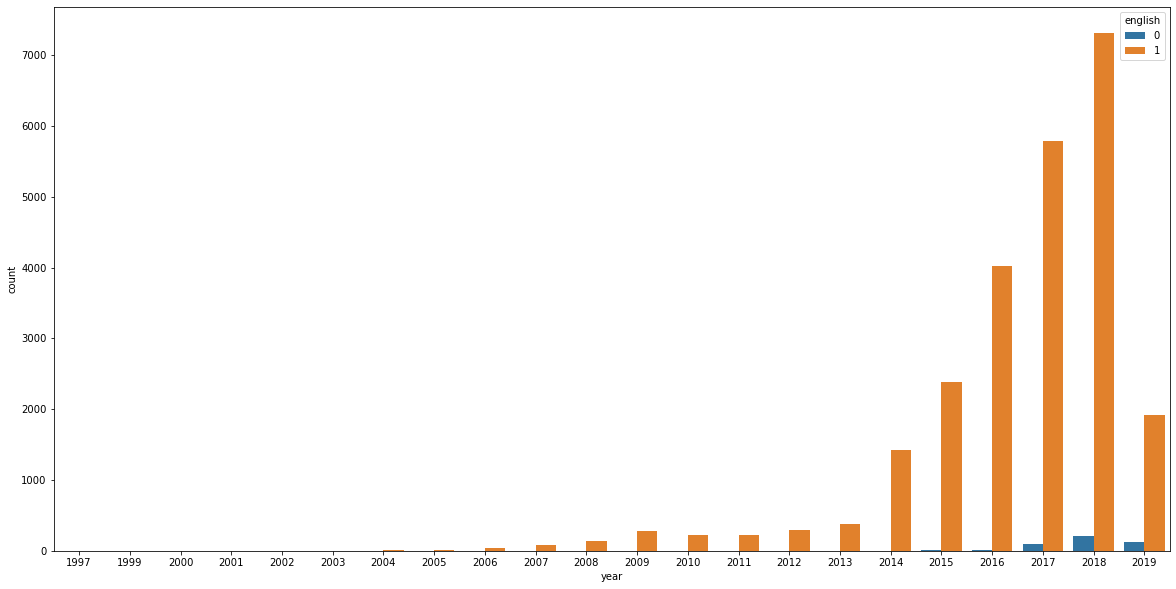

In [12]:
# to plot data distribution on basis of year release.
plt.figure(figsize=(20,10))
sns.countplot(x='year', hue='english', data=visual_data)

plt.show()

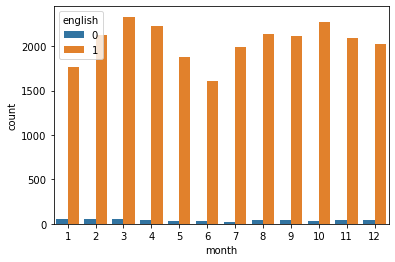

In [13]:
# to plot data distribution on basis of month release.
sns.countplot(x='month', hue='english', data=visual_data)
plt.show()

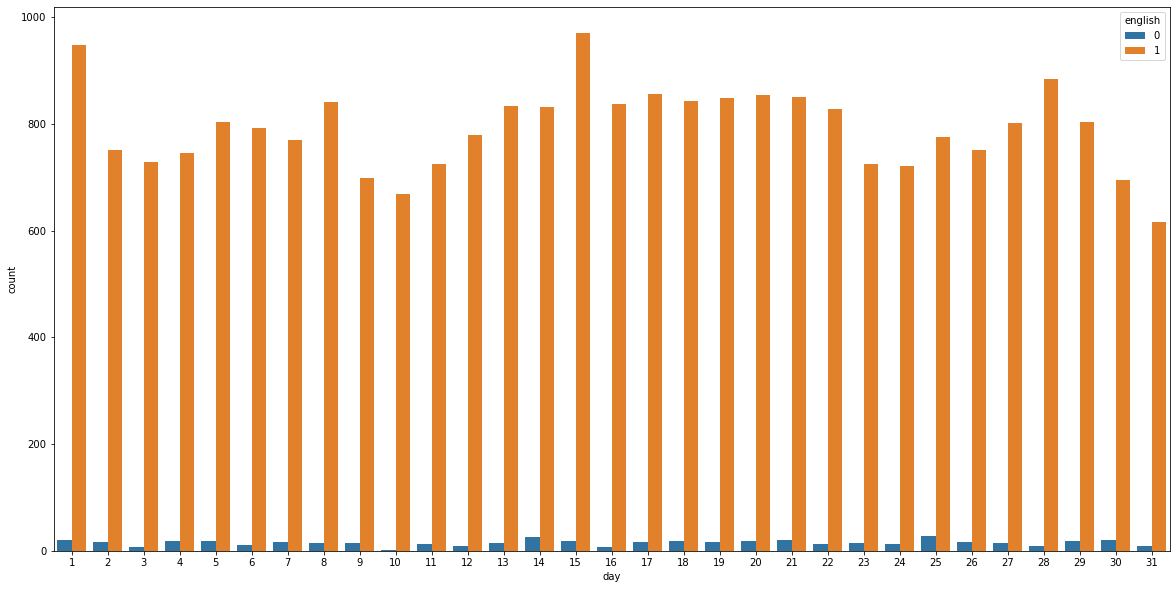

In [14]:
# to plot data distribution on basis of day release.
plt.figure(figsize=(20,10))
sns.countplot(x='day', hue='english', data=visual_data)
plt.show()

## Defining Helper functions for feature engineering and categorization

In [15]:
"""Distribution graphs (histogram/bar graph) of column data"""

def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [16]:
"""For plotting correlation matrix for unique columns"""
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    sns.heatmap(corr,annot=True,cmap='coolwarm')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [17]:
# calculate the avg rating of the game
def calc_rating(row):

    pos = row['positive_ratings']
    neg = row['negative_ratings']

    total_reviews = pos + neg

    average = pos / total_reviews

    score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))

    return score * 100


In [18]:
# to get unique categories from the column 
def get_unique(series):
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))

In [19]:
# to extract only years from release_date field.
def process_year(df):
    df['release_date'] = df['release_date'].astype('datetime64[ns]')
    df['release_year'] = df['release_date'].apply(lambda x: x.year)
    return df

In [20]:
# to process the data to use only relevant categories
def process_cat_gen_tag(df):
    cat_cols = get_unique(df['categories'])
    
    # remove comments to use all categories
    cat_cols = [
#         'Local Multi-Player',
#         'MMO',
#         'Mods',
        'Multi-player',
        'Online Co-op',
#         'Online Multi-Player',
        'Single-player'
    ]
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        
        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    gen_cols = get_unique(df['genres'])
    
    
    gen_cols = [
#         'Accounting',
        'Action',
        'Adventure',
#         'Animation & Modeling',
#         'Audio Production',
        'Casual',
#         'Design & Illustration',
#         'Documentary',
#         'Early Access',
#         'Education',
#         'Free to Play',
#         'Game Development',
#         'Gore',
        'Indie',
        'Massively Multiplayer',
#         'Nudity',
#         'Photo Editing',
        'RPG',
        'Racing',
#         'Sexual Content',
        'Simulation',
#         'Software Training',
        'Sports',
        'Strategy'
#         'Tutorial',
#         'Utilities',
#         'Video Production',
#         'Violent',
#         'Web Publishing'
    ]
    
    gen_col_names = []
    
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)
        
        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    #creating columns for platforms
    gen_cols = get_unique(df['platforms'])
    for col in sorted(gen_cols):
        col_name = col.lower()
        #gen_col_names.append(col_name)
        
        df[col_name] = df['platforms'].apply(lambda x: 1 if col in x.split(';') else 0)
      
    tag_cols = get_unique(df['steamspy_tags'])
    tag_cols = ['Story Rich','Sandbox','Open World','Multiplayer']
    
    for col in sorted(tag_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        
        df[col_name] = df['steamspy_tags'].apply(lambda x: 1 if col in x.split(';') else 0)
    
    # df['top_tag'] = df['tags'].apply(lambda x: x.split(';')[0] if ';' in x else x)
    
    # display(cat_cols, gen_cols, tag_cols)
    df = df.drop(['categories', 'genres', 'steamspy_tags','platforms','appid','name','release_date','developer','publisher'], axis=1)
    
    return df



In [21]:
# to call all the functions for pre-processing
def pre_process(df,n):
    df['owners'] = df['owners'].astype(str).str.split('-').apply(lambda x: (int(x[0]) + int(x[1])) / 2).astype(int)
#     df['owners'] = df['owners'].str.replace('[+,]', '').astype(int)
    
    # calculate ratings
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    df['ratings_ratio'] = df['positive_ratings'] / df['total_ratings']
    df['weighted_rating'] = df.apply(calc_rating, axis=1)
    df = df.drop(columns=['positive_ratings', 'negative_ratings'], axis=1)
    
    df = df.rename(columns={'average_forever': 'average_playtime', 'median_forever': 'median_playtime'})
    
    df = process_year(df)
        
    df = process_cat_gen_tag(df)
    
    return df



In [22]:
# getting unique entries from steamspy_tags
tag_cols = get_unique(train_df['steamspy_tags'])
tag_cols

{'1980s',
 "1990's",
 '2.5D',
 '2D',
 '2D Fighter',
 '360 Video',
 '3D',
 '3D Platformer',
 '3D Vision',
 '4 Player Local',
 '4X',
 '6DOF',
 'Abstract',
 'Action',
 'Action RPG',
 'Action-Adventure',
 'Adventure',
 'Agriculture',
 'Aliens',
 'Alternate History',
 'America',
 'Animation & Modeling',
 'Anime',
 'Arcade',
 'Arena Shooter',
 'Assassin',
 'Atmospheric',
 'Audio Production',
 'BMX',
 'Base-Building',
 'Baseball',
 'Basketball',
 'Batman',
 'Battle Royale',
 "Beat 'em up",
 'Beautiful',
 'Benchmark',
 'Bikes',
 'Blood',
 'Board Game',
 'Bowling',
 'Building',
 'Bullet Hell',
 'Bullet Time',
 'CRPG',
 'Capitalism',
 'Card Game',
 'Cartoon',
 'Cartoony',
 'Casual',
 'Cats',
 'Character Action Game',
 'Character Customization',
 'Chess',
 'Choices Matter',
 'Choose Your Own Adventure',
 'Cinematic',
 'City Builder',
 'Class-Based',
 'Classic',
 'Clicker',
 'Co-op',
 'Cold War',
 'Colorful',
 'Comedy',
 'Comic Book',
 'Competitive',
 'Controller',
 'Conversation',
 'Crafting',
 '

In [23]:
# getting different developers and their games count
temp={}
for i in train_df['developer']:
    tl=list(i.split(";"))
    for j in tl:
        if(j in temp.keys()):
            temp[j]+=1
        else:
            temp[j]=1

train_df.developer.value_counts().head(15)

Choice of Games               89
KOEI TECMO GAMES CO., LTD.    64
Ripknot Systems               58
Laush Dmitriy Sergeevich      48
RewindApp                     42
Nikita "Ghost_RUS"            41
Dexion Games                  40
Hosted Games                  39
Blender Games                 36
Humongous Entertainment       32
EnsenaSoft                    32
For Kids                      32
HeR Interactive               30
Warfare Studios               30
Eipix Entertainment           28
Name: developer, dtype: int64

In [24]:
# getting diferent owners on basis of their game count
train_df.owners.value_counts()

0-20000                17237
20000-50000             2820
50000-100000            1551
100000-200000           1275
200000-500000           1175
500000-1000000           474
1000000-2000000          267
2000000-5000000          177
5000000-10000000          42
10000000-20000000         20
20000000-50000000          3
50000000-100000000         2
100000000-200000000        1
Name: owners, dtype: int64

## Preprocessing the train and test data using above helper functions

In [25]:
train_df = pre_process(train_df,1)
train_df.dataframeName = 'training'

test_df= pre_process(test_df,0)
test_df.dataframeName= "testing"

nRow, nCol = train_df.shape
print(f'There are {nRow} rows and {nCol} columns after preprocessing')

train_df.head()

There are 25044 rows and 31 columns after preprocessing


,english,required_age,achievements,average_playtime,median_playtime,owners,price,total_ratings,ratings_ratio,weighted_rating,...,simulation,sports,strategy,linux,mac,windows,multiplayer,open_world,sandbox,story_rich
0,1,0,0,0,0,10000,2.89,4,0.500000,34.599704,...,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,10000,3.99,34,0.882353,73.106596,...,0,0,0,0,0,1,0,0,0,0
2,1,0,60,279,279,35000,10.29,301,0.900332,81.964286,...,0,0,0,1,1,1,0,0,0,0
3,1,0,53,0,0,10000,4.79,16,1.000000,78.690760,...,0,0,0,1,0,1,0,0,0,0
4,1,0,24,0,0,10000,7.19,30,0.966667,79.475627,...,0,0,1,1,1,1,0,0,0,0


# previewing data after preprocessing.

In [26]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2031 entries, 0 to 2030
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   english                2031 non-null   int64  
 1   required_age           2031 non-null   int64  
 2   achievements           2031 non-null   int64  
 3   average_playtime       2031 non-null   int64  
 4   median_playtime        2031 non-null   int64  
 5   owners                 2031 non-null   int64  
 6   total_ratings          2031 non-null   int64  
 7   ratings_ratio          2031 non-null   float64
 8   weighted_rating        2031 non-null   float64
 9   release_year           2031 non-null   int64  
 10  multi_player           2031 non-null   int64  
 11  online_co_op           2031 non-null   int64  
 12  single_player          2031 non-null   int64  
 13  action                 2031 non-null   int64  
 14  adventure              2031 non-null   int64  
 15  casu

In [27]:
test_df.columns

Index(['english', 'required_age', 'achievements', 'average_playtime',
       'median_playtime', 'owners', 'total_ratings', 'ratings_ratio',
       'weighted_rating', 'release_year', 'multi_player', 'online_co_op',
       'single_player', 'action', 'adventure', 'casual', 'indie',
       'massively_multiplayer', 'rpg', 'racing', 'simulation', 'sports',
       'strategy', 'linux', 'mac', 'windows', 'multiplayer', 'open_world',
       'sandbox', 'story_rich'],
      dtype='object')

In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25044 entries, 0 to 25043
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   english                25044 non-null  int64  
 1   required_age           25044 non-null  int64  
 2   achievements           25044 non-null  int64  
 3   average_playtime       25044 non-null  int64  
 4   median_playtime        25044 non-null  int64  
 5   owners                 25044 non-null  int64  
 6   price                  25044 non-null  float64
 7   total_ratings          25044 non-null  int64  
 8   ratings_ratio          25044 non-null  float64
 9   weighted_rating        25044 non-null  float64
 10  release_year           25044 non-null  int64  
 11  multi_player           25044 non-null  int64  
 12  online_co_op           25044 non-null  int64  
 13  single_player          25044 non-null  int64  
 14  action                 25044 non-null  int64  
 15  ad

# Plotting histograms to know dependencies.

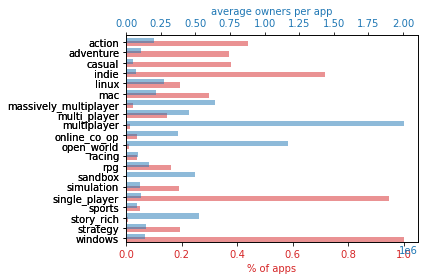

In [29]:
# percentage of apps in each genre

genre_cols = train_df.columns[-20:]

total_owners_per_genre = train_df[genre_cols].multiply(train_df['owners'], axis='index').sum()
average_owners_per_genre = total_owners_per_genre / train_df[genre_cols].sum()

fig, ax1 = plt.subplots()

color = 'tab:red'
train_df[genre_cols].mean().sort_index(ascending=False).plot.barh(ax=ax1, color=color, alpha=.5, position=.8)
# ax1.set_ylabel('genre')
ax1.set_xlabel('% of apps', color=color)
ax1.tick_params(axis='x', labelcolor=color)

ax2 = ax1.twiny()

color = 'tab:blue'
average_owners_per_genre.sort_index(ascending=False).plot.barh(ax=ax2, color=color, alpha=.5, position=.2, label='1')
ax2.set_xlabel('average owners per app', color=color)
ax2.tick_params(axis='x', labelcolor=color)

plt.tight_layout()
plt.show()

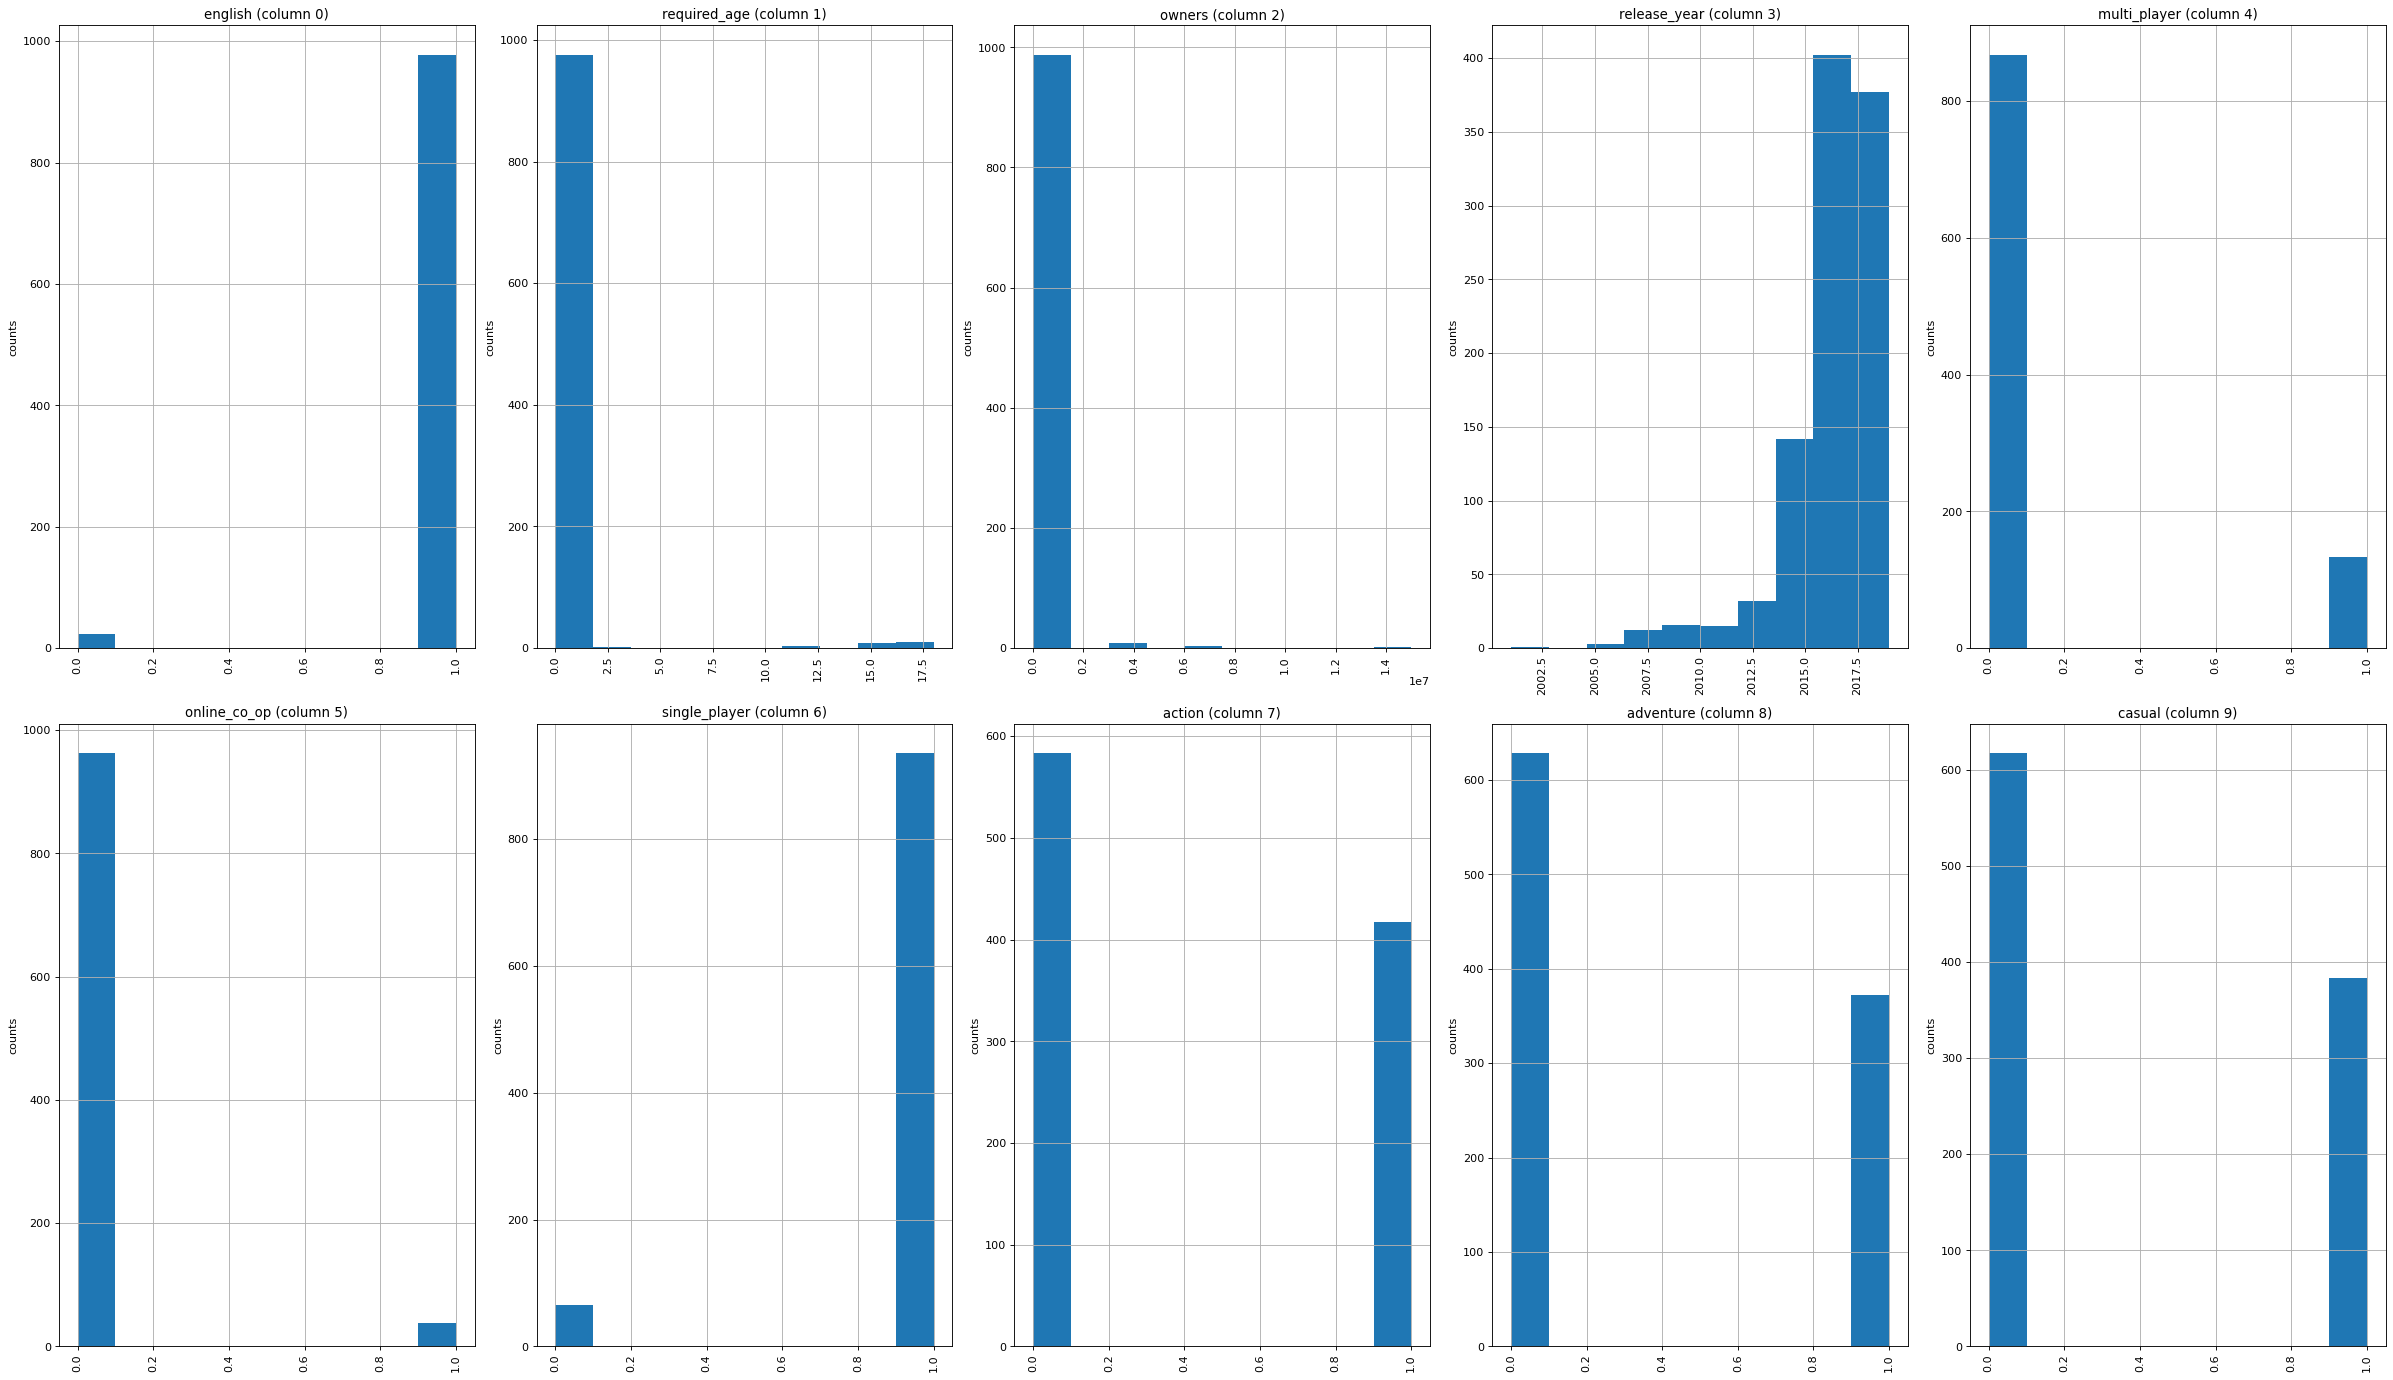

In [30]:
dfsample = train_df.sample(1000)
dfsample.dataframeName = 'train smaple'
plotPerColumnDistribution(dfsample, 10, 5)

# Plotting Correlation Matrix

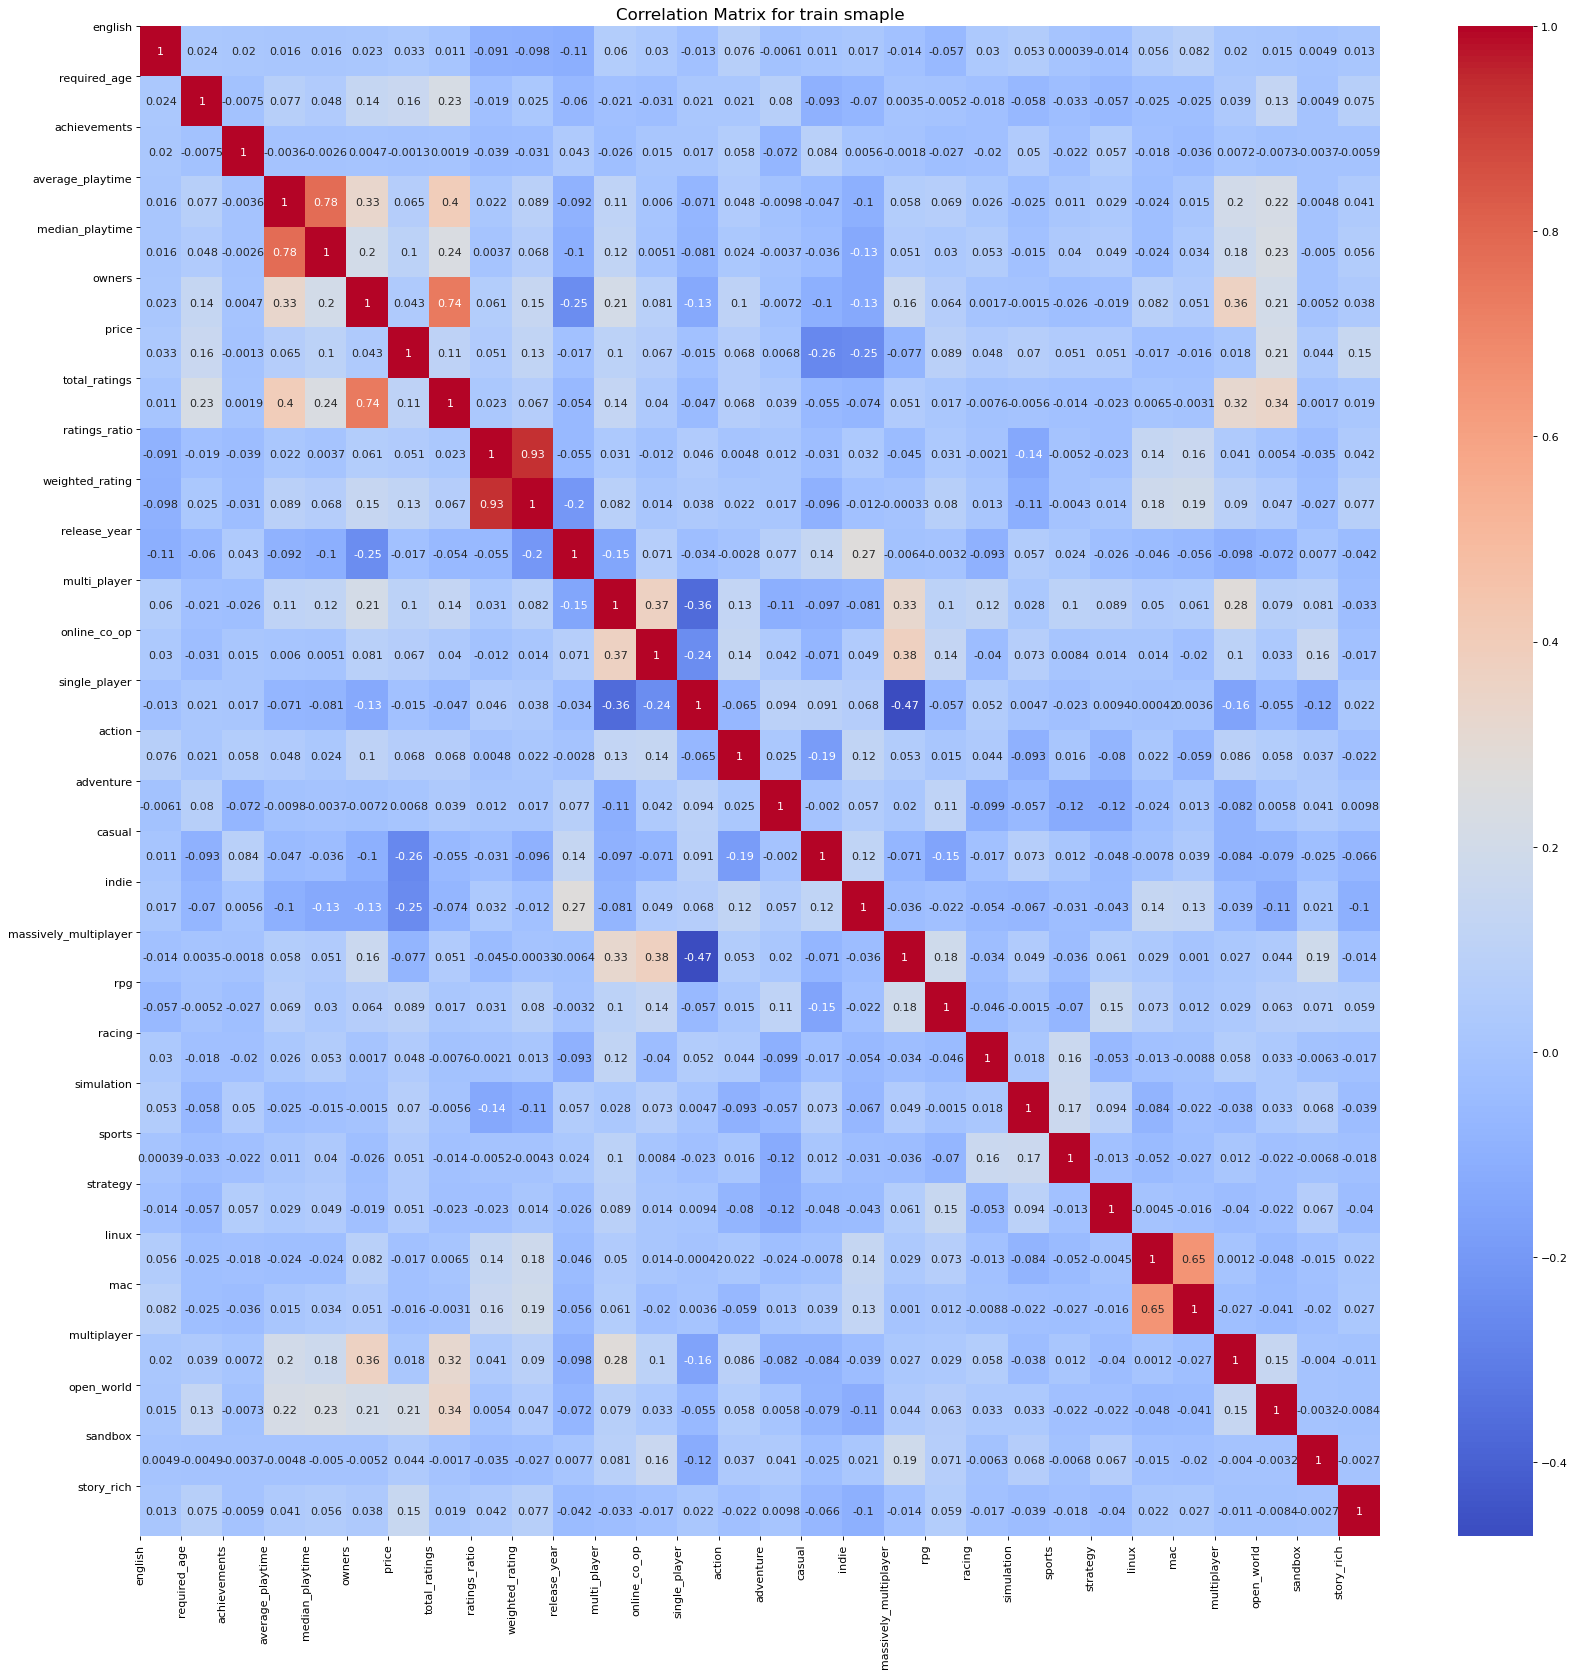

In [31]:
plotCorrelationMatrix(dfsample, 25)

In [32]:
test_df['price'] = -1
y_train = train_df.price
y_test = test_df.price
x_train = train_df.drop("price", axis =1)
x_test = test_df.drop("price", axis =1)
y_train = y_train.values
y_test = y_test.values
x_train = x_train.values
x_test = x_test.values

# Scaling data using Standard Scaler

In [33]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [34]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import metrics

## Spliting data for training and validation 

In [35]:
random_state = 0
Xtrain, Xtest, ytrain, ytest = train_test_split(x_train, y_train, random_state=random_state,test_size=0.1)

# defining RMSE value to check accuracy

In [36]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

## Using XG-Boost Model for prediction 

In [37]:
dtrain = xgb.DMatrix(Xtrain, ytrain)
dvalid = xgb.DMatrix(Xtest, ytest)

dtest = xgb.DMatrix(x_test, y_test)
d_all_train = xgb.DMatrix(x_train, y_train)

In [38]:
num_boost_round = 2000

eta = 0.01
max_depth = 7
subsample = 0.6
colsample_bytree = 0.4

# min_child_weight=1.5



print('XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'.format(eta, max_depth, subsample, colsample_bytree))
params = {
        "objective": "reg:squarederror",
        "booster" : "gbtree",
        "eval_metric": "rmse",
        "eta": eta,
        "tree_method": 'auto',
        "max_depth": max_depth,
        "subsample": subsample,
        "gamma":0,
#         "learning_rate":0.1,
#         "min_child_weight":min_child_weight,
        "colsample_bytree": colsample_bytree,
#         "silent": 1,
        "seed": 0
}

early_stopping_rounds = 15

XGBoost params. ETA: 0.01, MAX_DEPTH: 7, SUBSAMPLE: 0.6, COLSAMPLE_BY_TREE: 0.4


In [40]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

# gbm = xgb.cv(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

[0]	train-rmse:9.05343	eval-rmse:9.65143
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 15 rounds.
[1]	train-rmse:9.00967	eval-rmse:9.60892
[2]	train-rmse:8.96589	eval-rmse:9.56668
[3]	train-rmse:8.92493	eval-rmse:9.52670
[4]	train-rmse:8.88235	eval-rmse:9.48402
[5]	train-rmse:8.83997	eval-rmse:9.44463
[6]	train-rmse:8.79940	eval-rmse:9.40322
[7]	train-rmse:8.75843	eval-rmse:9.36398
[8]	train-rmse:8.71457	eval-rmse:9.32163
[9]	train-rmse:8.67248	eval-rmse:9.27978
[10]	train-rmse:8.63759	eval-rmse:9.24460
[11]	train-rmse:8.59905	eval-rmse:9.20679
[12]	train-rmse:8.56210	eval-rmse:9.17046
[13]	train-rmse:8.52776	eval-rmse:9.13738
[14]	train-rmse:8.49129	eval-rmse:9.10145
[15]	train-rmse:8.45606	eval-rmse:9.06677
[16]	train-rmse:8.42011	eval-rmse:9.03237
[17]	train-rmse:8.38231	eval-rmse:8.99461
[18]	train-rmse:8.34990	eval-rmse:8.96479
[19]	train-rmse:8.31609	eval-rmse:8.93186
[20]	train-rmse:8.28356	eva

[190]	train-rmse:5.92328	eval-rmse:6.72404
[191]	train-rmse:5.91965	eval-rmse:6.72200
[192]	train-rmse:5.91579	eval-rmse:6.71847
[193]	train-rmse:5.91018	eval-rmse:6.71428
[194]	train-rmse:5.90593	eval-rmse:6.71147
[195]	train-rmse:5.90189	eval-rmse:6.70800
[196]	train-rmse:5.89855	eval-rmse:6.70538
[197]	train-rmse:5.89407	eval-rmse:6.70120
[198]	train-rmse:5.88867	eval-rmse:6.69714
[199]	train-rmse:5.88160	eval-rmse:6.69213
[200]	train-rmse:5.87633	eval-rmse:6.68801
[201]	train-rmse:5.87095	eval-rmse:6.68444
[202]	train-rmse:5.86453	eval-rmse:6.67996
[203]	train-rmse:5.86095	eval-rmse:6.67643
[204]	train-rmse:5.85491	eval-rmse:6.67275
[205]	train-rmse:5.85078	eval-rmse:6.67043
[206]	train-rmse:5.84662	eval-rmse:6.66804
[207]	train-rmse:5.84200	eval-rmse:6.66548
[208]	train-rmse:5.83881	eval-rmse:6.66282
[209]	train-rmse:5.83164	eval-rmse:6.65807
[210]	train-rmse:5.82913	eval-rmse:6.65582
[211]	train-rmse:5.82526	eval-rmse:6.65305
[212]	train-rmse:5.82036	eval-rmse:6.64952
[213]	train

[381]	train-rmse:5.37848	eval-rmse:6.39495
[382]	train-rmse:5.37650	eval-rmse:6.39414
[383]	train-rmse:5.37417	eval-rmse:6.39337
[384]	train-rmse:5.37291	eval-rmse:6.39205
[385]	train-rmse:5.37018	eval-rmse:6.39058
[386]	train-rmse:5.36710	eval-rmse:6.38997
[387]	train-rmse:5.36559	eval-rmse:6.38969
[388]	train-rmse:5.36396	eval-rmse:6.38919
[389]	train-rmse:5.36234	eval-rmse:6.38865
[390]	train-rmse:5.36097	eval-rmse:6.38844
[391]	train-rmse:5.35794	eval-rmse:6.38607
[392]	train-rmse:5.35719	eval-rmse:6.38589
[393]	train-rmse:5.35581	eval-rmse:6.38539
[394]	train-rmse:5.35279	eval-rmse:6.38534
[395]	train-rmse:5.34969	eval-rmse:6.38409
[396]	train-rmse:5.34787	eval-rmse:6.38402
[397]	train-rmse:5.34708	eval-rmse:6.38346
[398]	train-rmse:5.34466	eval-rmse:6.38218
[399]	train-rmse:5.34355	eval-rmse:6.38150
[400]	train-rmse:5.34160	eval-rmse:6.38119
[401]	train-rmse:5.34106	eval-rmse:6.38082
[402]	train-rmse:5.33947	eval-rmse:6.37981
[403]	train-rmse:5.33824	eval-rmse:6.37947
[404]	train

[572]	train-rmse:5.11187	eval-rmse:6.30504
[573]	train-rmse:5.11056	eval-rmse:6.30440
[574]	train-rmse:5.10914	eval-rmse:6.30408
[575]	train-rmse:5.10775	eval-rmse:6.30382
[576]	train-rmse:5.10653	eval-rmse:6.30409
[577]	train-rmse:5.10588	eval-rmse:6.30375
[578]	train-rmse:5.10422	eval-rmse:6.30384
[579]	train-rmse:5.10345	eval-rmse:6.30331
[580]	train-rmse:5.10246	eval-rmse:6.30324
[581]	train-rmse:5.10157	eval-rmse:6.30308
[582]	train-rmse:5.10007	eval-rmse:6.30281
[583]	train-rmse:5.09964	eval-rmse:6.30255
[584]	train-rmse:5.09887	eval-rmse:6.30199
[585]	train-rmse:5.09812	eval-rmse:6.30195
[586]	train-rmse:5.09763	eval-rmse:6.30194
[587]	train-rmse:5.09502	eval-rmse:6.30190
[588]	train-rmse:5.09444	eval-rmse:6.30187
[589]	train-rmse:5.09323	eval-rmse:6.30142
[590]	train-rmse:5.09268	eval-rmse:6.30116
[591]	train-rmse:5.09110	eval-rmse:6.30122
[592]	train-rmse:5.09046	eval-rmse:6.30098
[593]	train-rmse:5.08983	eval-rmse:6.30061
[594]	train-rmse:5.08948	eval-rmse:6.30061
[595]	train

[763]	train-rmse:4.93941	eval-rmse:6.27188
[764]	train-rmse:4.93901	eval-rmse:6.27186
[765]	train-rmse:4.93867	eval-rmse:6.27191
[766]	train-rmse:4.93785	eval-rmse:6.27175
[767]	train-rmse:4.93724	eval-rmse:6.27124
[768]	train-rmse:4.93693	eval-rmse:6.27123
[769]	train-rmse:4.93441	eval-rmse:6.27116
[770]	train-rmse:4.93396	eval-rmse:6.27120
[771]	train-rmse:4.93313	eval-rmse:6.27088
[772]	train-rmse:4.93165	eval-rmse:6.27047
[773]	train-rmse:4.93096	eval-rmse:6.27029
[774]	train-rmse:4.93049	eval-rmse:6.27014
[775]	train-rmse:4.92966	eval-rmse:6.26982
[776]	train-rmse:4.92918	eval-rmse:6.26958
[777]	train-rmse:4.92787	eval-rmse:6.26977
[778]	train-rmse:4.92729	eval-rmse:6.26967
[779]	train-rmse:4.92564	eval-rmse:6.26944
[780]	train-rmse:4.92461	eval-rmse:6.26945
[781]	train-rmse:4.92432	eval-rmse:6.26936
[782]	train-rmse:4.92319	eval-rmse:6.26956
[783]	train-rmse:4.92235	eval-rmse:6.26929
[784]	train-rmse:4.92181	eval-rmse:6.26928
[785]	train-rmse:4.92144	eval-rmse:6.26933
[786]	train

[954]	train-rmse:4.80209	eval-rmse:6.25267
[955]	train-rmse:4.80085	eval-rmse:6.25277
[956]	train-rmse:4.80029	eval-rmse:6.25275
[957]	train-rmse:4.80019	eval-rmse:6.25272
[958]	train-rmse:4.79975	eval-rmse:6.25282
[959]	train-rmse:4.79896	eval-rmse:6.25267
[960]	train-rmse:4.79786	eval-rmse:6.25230
[961]	train-rmse:4.79708	eval-rmse:6.25221
[962]	train-rmse:4.79598	eval-rmse:6.25229
[963]	train-rmse:4.79573	eval-rmse:6.25224
[964]	train-rmse:4.79519	eval-rmse:6.25206
[965]	train-rmse:4.79479	eval-rmse:6.25190
[966]	train-rmse:4.79380	eval-rmse:6.25154
[967]	train-rmse:4.79373	eval-rmse:6.24966
[968]	train-rmse:4.79345	eval-rmse:6.24952
[969]	train-rmse:4.79278	eval-rmse:6.24979
[970]	train-rmse:4.79148	eval-rmse:6.24923
[971]	train-rmse:4.79101	eval-rmse:6.24914
[972]	train-rmse:4.79033	eval-rmse:6.24889
[973]	train-rmse:4.78981	eval-rmse:6.24843
[974]	train-rmse:4.78946	eval-rmse:6.24853
[975]	train-rmse:4.78891	eval-rmse:6.24863
[976]	train-rmse:4.78782	eval-rmse:6.24834
[977]	train

# Checking the importance of all features

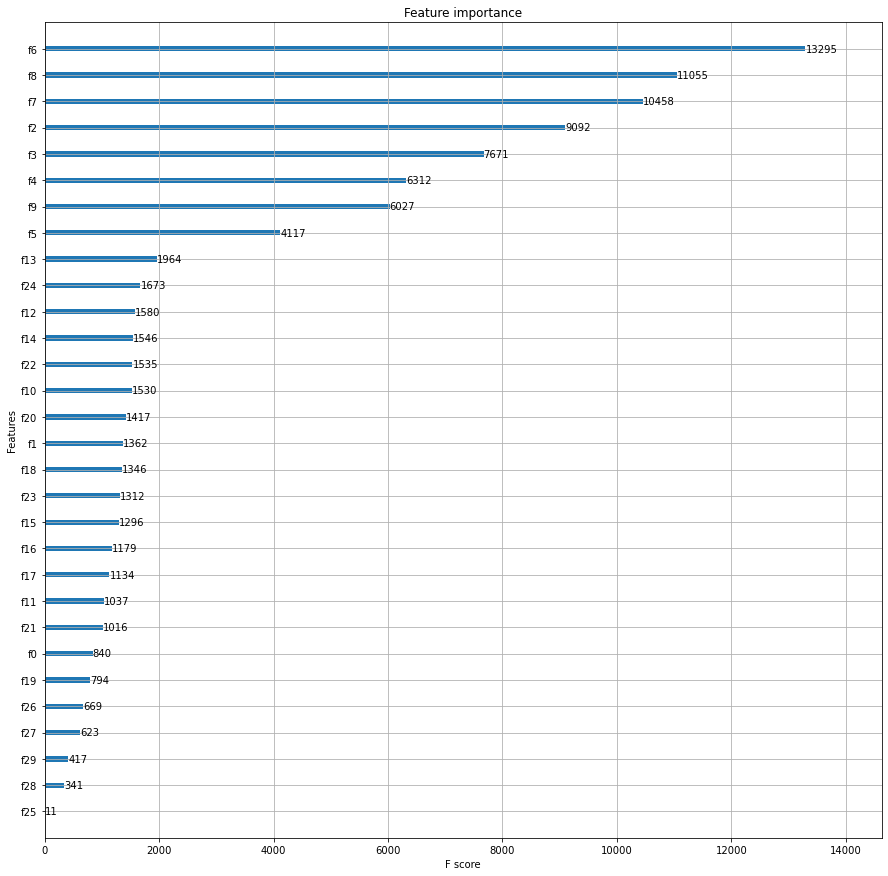

In [42]:
xgb.plot_importance(gbm)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

6.249315841803649


NameError: name 'y' is not defined

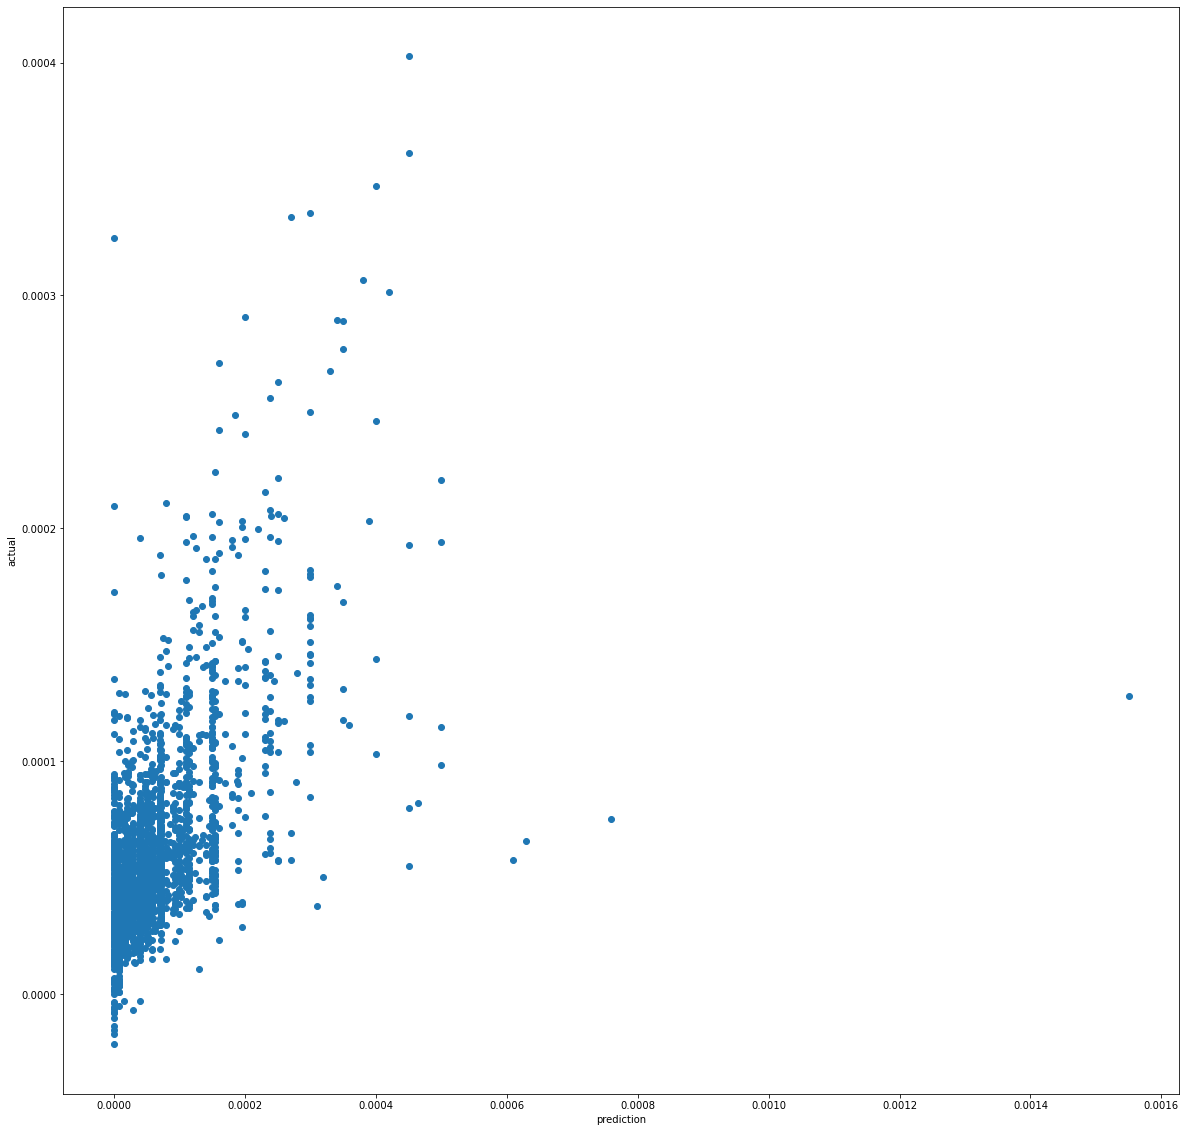

In [51]:
ypred = gbm.predict(dvalid)
print(rmse(ytest, ypred))
plt.scatter((ytest)/100000, (ypred)/100000,cmap='coolwarm')
plt.xlabel('prediction')
plt.ylabel('actual')

plt.plot(ypred,y)
plt.xlim(-1,9)
plt.ylim(-1,9)

In [52]:
rmse(ytest, ypred)

6.249315841803649

In [53]:
num_boost_round = 1500
gbm = xgb.train(params, d_all_train, num_boost_round) # training over whole training data

## Predicting over final test data and creating submission

In [54]:
prediction = gbm.predict(dtest)

In [55]:
prediction

array([3.6713989, 7.7150235, 6.038832 , ..., 5.5207386, 4.668745 ,
       3.7715633], dtype=float32)

In [56]:
sub_df = pd.DataFrame({'appid':test_id,'price': prediction })
sub_df.describe()


,appid,price
count,2.031000e+03,2031.000000
mean,5.992926e+05,6.189126
std,2.443364e+05,4.276019
min,7.000000e+01,-3.354025
25%,3.998350e+05,3.666129
50%,6.038100e+05,5.126049
75%,7.990200e+05,7.292043
max,1.062670e+06,37.066437


In [57]:
sub_df

,appid,price
0,514520,3.671399
1,1012710,7.715024
2,279260,6.038832
3,220090,6.664261
4,788870,5.049582
...,...,...
2026,9940,9.119424
2027,983880,6.590319
2028,687760,5.520739
2029,391290,4.668745


In [ ]:
sub_df.to_csv('version6.csv', index = False)